# Object Detection
 
Hello, this is a very minimal notebook showing a working object detection network using just ~300 lines of modelling and training code. In this lab you will code an object detection with functionality similiar to a Single Shot Detector or YOLO detector. 
 
The first steps would be to understand what anchors are. Anchors are nothing but crops of a specific size and position in the image. The job of our object detector is to classify each anchor as containing an object or not. If the anchor contains an object, we want to find out by how much our anchor needs to change in shape and position to best fit the object in it. (By how much the height, width and center x and y cordinates change.)
 
Hence, object detection is a multi task network which does classification and regression.
 
 
The final objective of completing this notebook is to generate some visualizations of the network running on images in the validation set. In addition to this, please upload the weights of your network and share the google drive link. In this notebook below:
 
**Fill this out with the Google drive link containing model weights**
...
 
You should upload the completed notebook to NYU Brightspace.

In [72]:
# load important modules
!git clone https://github.com/karanchahal/objectdetection-
%cd objectdetection-

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: could not create work tree dir 'objectdetection-': Transport endpoint is not connected


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-72-ae0ed6226e93>", line 3, in <module>
    get_ipython().magic('cd objectdetection-')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-84>", line 2, in cd
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception,

FileNotFoundError: ignored

In [71]:
from extras.shapes_loader import get_shapes_loader
from extras.util import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
from extras.encoder import ResnetEncoder
import torch.nn.functional as F
# My code
# import numpy as np
# My code
from extras.anchors import get_offsets
from extras.boxes import box_iou, nms
 
trainloader, valloader = get_shapes_loader(batch_sz=4)
device = 'cpu' # change this to "cuda" if you have access to a GPU. On CPU, training should take around ~45 mins on CPU.
 
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

## Dataset

First let's introduce our dataset. We have a Pytorch dataloader which outputs images and the ground truth data for the bounding boxes. We visualize the dataset below. You dont need to write any code here. However, you should dig into the fun ction that are called to better understand the structure of the dataset. 

In [73]:
sample, target = iter(trainloader).next()
sample = torch.stack(sample,dim=0)

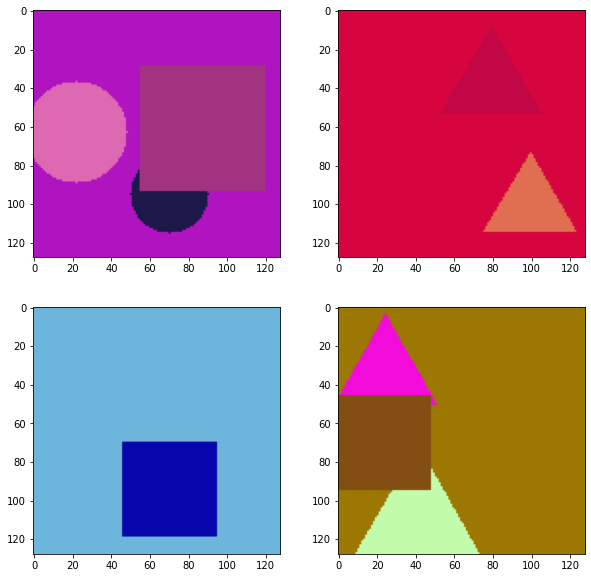

In [74]:
vis(sample)

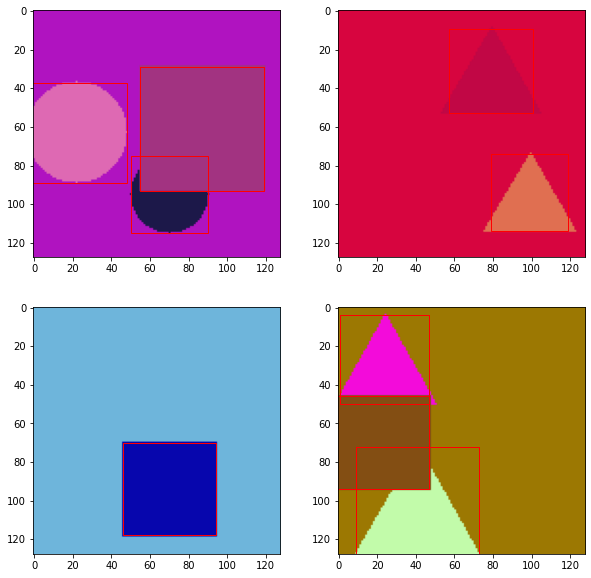

In [75]:
visDet(sample, target)

### Target Data for the Dataset

The labels/targets of the datset have 2 types of data for each image. 

1. The bounding boxes which is a tensor of size (N x 4).
here is N is the number of objects in the image and 4 correspond to:

    a. top left x coordinate
    b. top left y coordinate
    c. bottom right x coordinate
    d. bottom right y coordinate

2. The second type of targets are the classification labels of size Nx1. Here N corresponds to the number of objects in the image and the 1 corresponds to the label of the object (whether it is a triangle, square or circle).


In [76]:
print(target[0])

{'bounding_box': tensor([[ 50,  75,  90, 115],
        [ -4,  37,  48,  89],
        [ 55,  29, 119,  93]]), 'labels': tensor([2, 2, 1], dtype=torch.int32)}


### Converting Target Data to Ground Truth 

Here we assign bounding boxes to the various anchor boxes in our image. Anchor boxes are rectangular chunks in the image and are spread all across the image. In object detection, we divide the image into a large number of chunks of different sizes and specify two characteristics of that chunk:

1. Whether it has an object in it or not. This is done by measuring IOU of the chunk with the bounding boxes. If the IOU is > 0.7, we say that the chunk contains the object. If it is less than 0.3, we say the chunk only contains background. If the value is somewhere in between, we say it is a bad chunk and do not use it's contribution to the loss in our backpropogation.

2. How much should the chunk change in height, width and how much should it translate to best fit the object. These offsets are 4 values, for the height, width, center x and y coordinate. You should use measurements relative to the default anchor position/scale (see below for more details on the anchors).


Anchor boxes might be explained best by this image:
![Anchor Boxes](https://lilianweng.github.io/lil-log/assets/images/SSD-framework.png)

Now, first we create the chunks or "anchors" for our image. Since our image is 128x 128 in size. In this lab we want to use a stride of 16.  Hence, we should get 192 anchors.


### Why do we get the size 192 ?

We get the size of 192 as we have a total of 192 anchors in an image of 128 x 128 while using a stride of 16 and we have 3 anchors in each position of the image. 

Let's break this down.

128/16 = 8.

Hence, our neural network should output a feature map of 8 x 8 in spatial dimensions. Each grid in this feature map is an anchor position. Each position has 3 boxes/anchors with default shapes -> size 40x40, 50x50 and 60x60, centered at each position.

Hence the total anchors are 8x8x3 = 192. 

Your first job is to write the code that creates these 192 anchors from an image of size 128x128. Each anchor is represented by the top left and bottom right x,y coordinates of the anchors in regards with a 128x128 image. 

Hence, the output of the below function should be a tensor of size [192,4]


In [77]:
stride = 16 # The stride of the final feature map is 16 (the model compresses the image from 128 x 128 to 8 x 8)
map_sz = 128 # this is the length of height/width of the image

scales = torch.tensor([40,50,60])
ratios = torch.tensor([[1,1]]).view(1,2)

def get_value_sub(value, scale, ratios):
    value_max = 127 - scale * ratios
    value_min = 0
    value = min(value, value_max)
    value = max(value, value_min)
    return value


def get_value_add(value, scale, ratios):
    value_max = 127
    value_min = 0 + scale * ratios
    value = min(value, value_max)
    value = max(value, value_min)
    return value

def get_gt_boxes():
    """
    Generate 192 boxes where each box is represented by :
    [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    Each anchor position should generate 3 boxes according to the scales and ratios given.

    Return this result as a numpy array of size [192,4]
    """


    # ready = []
    gt_boxes = []
    # gt_boxes = torch.from_numpy(ready)

    for i in range(8):
        for j in range(8):
            x_center = i * stride + stride / 2
            y_center = j * stride + stride / 2
            #print(" x = {}, y ={}".format(x_center, y_center))
            for s in range(len(scales)):
                x0 = x_center - scales[s] * ratios[0][0] / 2
                x1 = x_center + scales[s] * ratios[0][0] / 2
                y0 = y_center - scales[s] * ratios[0][1] / 2
                y1 = y_center + scales[s] * ratios[0][1] / 2


                nx0 = get_value_sub(x0, scale=scales[s], ratios=ratios[0][0])
                nx1 = get_value_add(x1, scale=scales[s], ratios=ratios[0][0])
                ny0 = get_value_sub(y0, scale=scales[s], ratios=ratios[0][1])
                ny1 = get_value_add(y1, scale=scales[s], ratios=ratios[0][1])


                gt_box = [nx0, ny0, nx1, ny1]
                #print(" x0 = {}, y0 ={}, x1 = {}, y1 ={}".format(nx0, ny0, nx1, ny1))
                gt_boxes.append(gt_box)

                # gt_boxes = torch.vstack((gt_boxes, gt_box))
    return torch.tensor(gt_boxes)

gt_boxes = get_gt_boxes()
# In the instruction, we are supposed to return the gt_boxes as a numpy array, however, the next line calls "assert gt_boxes.size() == (192,4)". Should not this be
# "assert gt_boxes.size == (768)" since it is a numpy array?
# Sorry for the ambiguities. You can return it as a torch.tensor instead and the assertion will hold in that case.
assert gt_boxes.size() == (192,4)

# A Pictoral Representation of our Model

![alt text](https://cdn-images-1.medium.com/max/1600/1*7heX-no7cdqllky-GwGBfQ.png)


However instead of $2k$ in the given image we just have k scores. We group triangles, squares and circles into one foreground class for this demo. Of course, we can have seperate predictions for each class but that is added complexity and is not implemented here.


Your next job is to construct the model. Most parts of the model is already constructed, your job is to add the classification and bounding box regression heads to the encoder.

In [78]:
class ShapesModel(nn.Module):

    def __init__(self):
        super(ShapesModel, self).__init__()

        # for each grid in the feature map we have 3 anchors of sizes: 40x40, 50x50, 60x60
        num_anchors = 3

        # regular resnet 18 encoder
        self.encoder = ResnetEncoder(num_layers=18, pretrained=False)
        # a small conv net
        self.conv = nn.Conv2d(
            256, 256, kernel_size=3, stride=1, padding=1
        )

        # TODO: Add a Convolutional Layer to prediction the class predictions. This is a head that predicts whether a chunk/anchor contains an object or not.
        self.cls_logits = nn.Conv2d(256, 3, 3, stride=1, padding=1, bias=False)
        
        # 
        # self.cls_logits = None

        # TODO: Add a Convolutional Layer to prediction the class predictions. This is a  a head that regresses over the 4 bounding box offsets for each anchor
        self.bbox_pred = nn.Conv2d(256, 12, 3, stride=1, padding=1, bias=False)
       
        # 
        # self.bbox_pred = None
    
    def permute_and_flatten(self, layer, N, A, C, H, W):
        # helper function that rearranges the input for the loss function
        layer = layer.view(N, -1, C, H, W)
        layer = layer.permute(0, 3, 4, 1, 2)
        layer = layer.reshape(N, -1, C)
        return layer
    
    def get_predict_regressions(self, cls_pred, box_pred):
        # helper function that gets outputs in the right shape for applying the loss
        N, AxC, H, W = cls_pred.shape
        Ax4 = box_pred.shape[1]
        A = Ax4 // 4
        C = AxC // A
        cls_pred = self.permute_and_flatten(
            cls_pred, N, A, C, H, W
        )
        
        box_pred = self.permute_and_flatten(
            box_pred, N, A, 4, H, W
        )
        return cls_pred, box_pred

    def forward(self, x):
      # x.size() == (1, 3, 128, 128)
        bt_sz = x.size(0)

        # we take the 3rd output feature map of size 8 x 8 from
        # the resnet18 encoder this means that the stride
        # is 16 as our input image is 128x128 in size.
        x = self.encoder(x)[3]

        # print (x.shape)
        # x.size() == (1, 256, 8, 8)
        x = F.relu(self.conv(x))

        # print (x.shape)

        cls_pred = self.cls_logits(x)

        # print (cls_pred.shape)
        # cls_pred.size() == (1, 3, 8, 8)
        box_pred = self.bbox_pred(x)
        # print (box_pred.shape)
        # box_pred.size() == (1, 12, 8, 8)
        cls_pred, box_pred = self.get_predict_regressions(cls_pred, box_pred)
        # cls_pred.size() == (1, 192, 1)
        # box_pred.size() == (1, 192, 4)
        
        return cls_pred.squeeze(2), box_pred


In [79]:
m = ShapesModel()
a = torch.randn(1,3,128,128) # dummy input
cls_pred, box_pred = m(a)
print('The outputs of the net are of size: ', cls_pred.size(), box_pred.size())

assert cls_pred.size() == (1,192) and box_pred.size() == (1,192,4)

The outputs of the net are of size:  torch.Size([1, 192]) torch.Size([1, 192, 4])


Each anchor is represented by the top left and bottom right x,y coordinates of the anchors in regards with a 128x128 image. 

Next we have to assign a class label to each anchor and in case the anchor has an IOU > 0.7 with any real object assign 4 offsets to the anchor. We do this for every single image. Each image would have it's own set of anchors with different class probabilities and offsets as that depends on what objects are situated in that image. 

Your job is to calculate those values. Fill out the below function. Hint: Use the `box_iou` and `get_offsets` function.

In [80]:
def get_bbox_gt(ex_boxes, gt_boxes, sz=128):
    '''
    
    INPUT:
    ex_boxes: [Nx4]: Bounding boxes in the image. Here N is the number of bounding boxes the image has
    gt_boxes: [192 x 4]: Anchor boxes of an image of size 128 x 128 with stride 16. 
    sz : 128
    OUTPUT: 
    gt_classes: [192 x 1] : Class labels for each anchor: 1 is for foreground, 0 is for background and -1 is for a bad anchor. [where IOU is between 0.3 and 0.7]
    gt_offsets: [192 x 4]: anchor#(先验框v3之后)# Offsets(偏移量) for anchor to best fit the bounding box object. 0 values for 0 and -1 class anchors.
    #hioulist = torch.max(iou_t, 1)#?这里是一横行，如何转成竖列？
    #highestiou = torch.transpose(hioulist, 0, 1)#竖列 01 和10 有什么区别？https://www.cnblogs.com/tingtin/p/13547653.html
    # box_iou: https://pytorch.org/vision/stable/ops.html
    # get_offsets: https://matplotlib.org/stable/api/collections_api.html
    '''

    high_threshold = 0.7
    low_threshold = 0.3
    iou_t = box_iou(gt_boxes, ex_boxes) # tensor (192*n)这里是n种anchorbox*192组成的tensor

    
    gt_class = torch.zeros(192, 1)
    for i in range(192):
      if torch.max(iou_t[i]) >= high_threshold:
        gt_class[i] = 1
      if torch.max(iou_t[i]) <= low_threshold:
        gt_class[i] = 0
      if torch.max(iou_t[i]) > low_threshold and torch.max(iou_t[i]) < high_threshold:
        gt_class[i] = -1
      
    gt_classes = torch.Tensor(gt_class)

    #print (gt_classes.shape)#gt_classes torch.Size([192, 1])

    
    #gt_offsets = torch.zeros(192,4)
    # for i in range(N, 192):
    #   ex_boxes[i] = [0, 0, 0, 0]
    #N = ex_boxes.shape[0]
    #gt_offsets = []
    #gt_offsets = zeros(192,4)
    # gt_offsets = torch.zeros(192,4)
    # for i in range(192):#(i到range 192)
    #   if gt_classes[i] == 1:
    #     gt_offsets[i] = get_offsets(gt_boxes[i], ex_boxes[torch.argmax(iou_t[i])]) 

    #yolo V1 或者V2
    testoffsets = torch.zeros(192,4)
    for i in range(192):#(i到range 192)
      if gt_classes[i] == 1:
        #print(gt_boxes[i].shape)
        #print(ex_boxes[torch.argmax(iou_t[i])].shape)
        testoffsets[i] = get_offsets(torch.unsqueeze(gt_boxes[i], 0), torch.unsqueeze(ex_boxes[torch.argmax(iou_t[i])], 0))
        
    
    gt_offsets = torch.tensor(testoffsets) 
    # gt_offsets = get_offsets(gt_final, ex_boxes)
    # Consider the max IOU of each anchor with the bounding boxes for further calculations (0.6 in this example you shared)
    # help on get offsets:https://piazza.com/class/ksdsdw4d8166f7?cid=102

    return gt_classes, gt_offsets

In [81]:
def get_targets(target, sample):
    '''
    Input
    target => Set of bounding boxes for each image.
    Sample => Each image
    Output:
    Bounding box offsets and class labels for each anchor.
    '''

    batched_preds = []
    batched_offsets = []
    final_cls_targets = []
    final_box_offsets = []
    for t, s in zip(target, sample):
        bboxes = t['bounding_box'].to(device).float()
        class_targets, box_offsets = get_bbox_gt(bboxes, gt_boxes, sz=128)
        final_cls_targets.append(class_targets)
        final_box_offsets.append(box_offsets)
    
    final_cls_targets = torch.stack(final_cls_targets, dim=0)
    final_box_offsets = torch.stack(final_box_offsets, dim=0)

    return final_cls_targets, final_box_offsets

In [82]:
sample, target = iter(trainloader).next()
sample = torch.stack(sample,dim=0)

class_targets, box_targets = get_targets(target, sample)
#class_targets = class_targets.squeeze(2)
print(class_targets.size(), box_targets.size())
#torch.Size([4, 192]) torch.Size([4, 192, 4])

torch.Size([4, 192, 1]) torch.Size([4, 192, 4])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is the meat of object detection right there ! The correct calculation of the anchors for an image and it's ground truth. Now that this is done, we can move on to our neural network training code.

## Loss Function

One more small kink in the puzzle of object detection is the way the classification loss is calculated. Here, the classification loss is the binary cross entropy loss. The loss is calculated only for those anchors which are background and foreground anchors NOT the negative ones. 

One more kink in this setup is that we should sample background and foreground anchors in the ratio of 3:1. This is because there are too many background anchors and the model will predict a background anchor for every anchor and still get a 90% accuracy on the classification. To prevent this, we do this sampling which is also called hard online negative sampling. However, as we have a very small amount of anchors here (192) this isn't a problem. However, for smaller strides and different scales and ratios for each position, thie number can balloon to upto 100,000. Hence, implementing hard online negative sampling is left to be optional to you.

For the bounding box regressions, use a Smooth L1 loss, this works well and prevents outliers.

Your next task is to write the code for the class_loss and bbox_loss. The classification loss should be applied to all positive (containing an object) and negative anchors (does not contain an object). The loss should not be calculated for the anchors whose IOU values are between 0.7 and 0.3.

Apply a Smooth L1 loss to regress on the bounding box offsets, (only apply this loss for anchors which contain an object !)

**Extra Credit**: Implement Hard Online Negative Sampling, however it is not necessasary. You can get this model to train without using it as the number of anchors are low for an image in this case.



In [83]:

def class_loss(out_pred, class_targets, device="cpu"):
    #background and foreground anchors NOT the negative ones.
    #https://github.com/WongKinYiu/PyTorch_YOLOv4/blob/master/utils/loss.py line62 define compute loss?
    #sample background and foreground anchors in the ratio of 3:1
    class_targets = class_targets.view(4, 192)
    pick_pred = out_pred[class_targets >= 0]
    pick_target = class_targets[class_targets >= 0]
    criterion = nn.BCELoss()
    
    #print(out_pred.shape)
    losscl = criterion(torch.sigmoid(pick_pred), pick_target)
    return losscl
    
def bbox_loss(out_bbox, box_targets, class_targets):
    device = "cpu"
    class_targets = class_targets.view(4, 192)
    criterion = nn.SmoothL1Loss()
    #print(out_bbox.shape)
    #print(box_targets.shape)
    pick_pred = out_bbox[class_targets == 1]
    pick_target = box_targets[class_targets == 1]
    #print([class_targets == 1])
    #print([class_targets == 1].shape)

    #print(box_targets[class_targets == 1].shape)
    #out_bbox = out_bbox.reshape(4, 192, 4)
    #box_targets = box_targets.reshape(4, 192, 4)
    lossl1 = criterion(pick_pred, pick_target)
    return lossl1

## Training Function. 

This is the training function, you do not need to change any code here. You can add a validation function here to verify that your model is working well. However, you do not need to submit it.

In [84]:
def train(ep, model, trainloader, optimizer):
        total_loss = 0
        b_loss = 0
        c_loss = 0
        for i, (ims, targets) in enumerate(trainloader):
            ims = torch.stack(list(ims), dim=0).to(device)

            class_targets, box_targets = get_targets(targets, ims)
            out_pred, out_box = model(ims)
            loss_cls = class_loss(out_pred, class_targets)
            loss_bbox = bbox_loss(out_box, box_targets, class_targets)
            loss = loss_cls + loss_bbox

            if loss.item() != 0:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            c_loss += loss_cls.item()
            b_loss += loss_bbox.item()
            
        avg_c_loss = float(c_loss / len(trainloader))
        avg_b_loss = float(b_loss / len(trainloader))
        print('Trained Epoch: {} | Avg Classification Loss: {}, Bounding loss: {}'.format(ep, avg_c_loss, avg_b_loss))

In [85]:
model = ShapesModel().to(device)
optimizer = torch.optim.SGD(
        model.parameters(),
        lr=0.1, momentum=0.9, weight_decay=1e-4)    
for ep in range(4):
    train(ep, model, trainloader, optimizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Trained Epoch: 0 | Avg Classification Loss: 0.15607925321161747, Bounding loss: nan
Trained Epoch: 1 | Avg Classification Loss: 0.12297696067094803, Bounding loss: nan
Trained Epoch: 2 | Avg Classification Loss: 0.10474161656349898, Bounding loss: 0.003388514265581034
Trained Epoch: 3 | Avg Classification Loss: 0.0481084823015146, Bounding loss: 0.004213417753740214


In [98]:
#Load the Drive helper and mount
from google.colab import drive
print("0")
drive.mount('/content/drive', force_remount=True)
#drive.mount('/content/drive/"My Drive"/')
print("1")
#%cd "/content/drive/'My\ Drive'/"
print("2")
#torch.save(model.state_dict(), 'modelweight4ep.pth')


0
Mounted at /content/drive
1
2


https://drive.google.com/file/d/1LUcaNZ02-G_hWGhpWfooNm2lG2vvtT8e/view?usp=sharing

### Now let's visualize the predictions !

The most exciting part of any neural network model setup. First let's visualize our ground truth.

In [95]:
sample, target = iter(valloader).next()
sample = torch.stack(sample,dim=0)

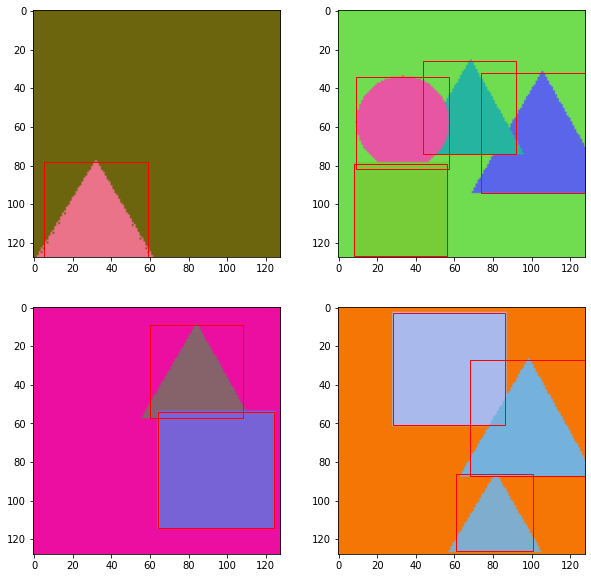

In [96]:
visDet(sample, target)

### Our Model Predictions

Note: We perform NMS upon our final predictions to clear up the output. This is done as a lot of anchors near to the actual object will fire resulting in a lot of boxes. NMS handles these multiple predictions by merging and giving a single box for a predicted object instead of multiple. This is best signified through another image:

![NMS](https://miro.medium.com/max/1000/0*WI5_K3bAbYaRyzE-.png)

Now onto our model predictions !

Your final task is to write code to visualize the model predictions on an image in the validation set. You can use the `visDet` function to help out with visualizing. Your main job would be to select what anchors (after applying offsets) to draw on the image. Generally, if the probability is > 0.7. It's a good idea to use the anchor. Also, you can use the `nms` function inside `boxes.py`.


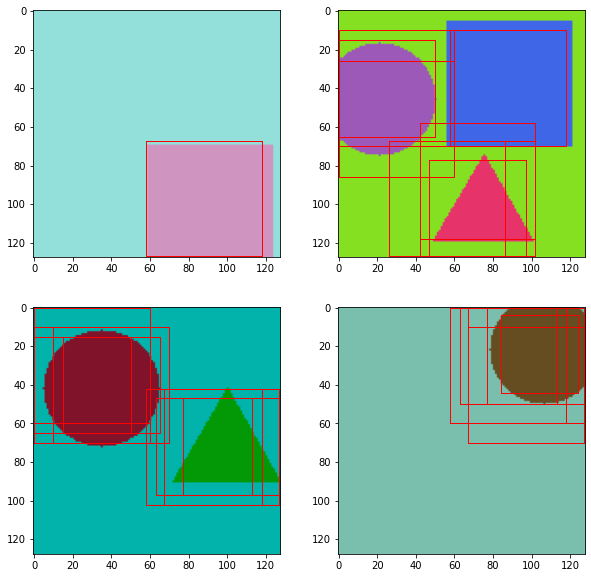

In [ ]:
# nms: 非极大值抑制
def visPred(model, sample):
  output_pred, output_box = model(sample.to(device))
  testboxes = get_gt_boxes()
  test_list = []
  for i in range(len(sample)):
    picked_boxes = testboxes[torch.sigmoid(output_pred[i])>0.7]
    result = {'bounding_box': picked_boxes, 'labels':None}
    test_list.append(result)
  test_list = tuple(test_list)
  return visDet(sample, test_list)
#def nms(boxes, scores, iou_threshold):
#type: (Tensor, Tensor, float)
#TODO: visualize your model predictions on the sample image.
# visDet(sample, target)''' Assumes batch size of 4'''
visPred(model, sample)

In [ ]:
.

## Conclusion

Not bad, right ? This is a very barebones implementation and trained for a very short amount of epochs. However this is the meat and bones of most anchor based state of the art detectors out today. We can improve accuracy by doing multiscale training by incorporating a Feature Pyramid Network but that is for you to discover :') 

## References

Some foundational/good papers on object detection. This list is non exhaustive

1. [Single Shot Detector](https://arxiv.org/abs/1512.02325)
2. [YOLO](https://arxiv.org/abs/1612.08242)
3. [Faster RCNN](https://arxiv.org/abs/1506.01497)
4. [Feature Pyramid Network](https://arxiv.org/abs/1612.03144)
5. Bonus Read: [DETR- State of the art Object detector based on Transformers](https://arxiv.org/abs/2005.12872)
